# Model Experimentation
This notebook is designed to streamline experimentation with different models.

1. Selecting a model, dataset, tracker and hyperparameters
2. Training the model and evaluating both object detection and tracking performance
3. Saving the results in wandb
4. Storing the model and evaluation annotations in a folder
5. **Investigation** of the results, detection of failure cases and model improvement
6. **Iterating** over steps 1-5



In [1]:
from architectures import yolov8
from trackers import botsort
from data import yolo_dataset
import wandb
import json

> run `wandb login` in terminal before running this notebook

### Select a model, dataset, tracker and hyperparameters

In [2]:
architectures = {
  "yolov8": yolov8.YoloV8
}

trackers = {
  'botsort': botsort.BotSort
  }

dataset_mapping = {
 "yolov8": yolo_dataset.YoloDataset
  }

In [3]:
required_train_params = ["architecture", "epochs", "batch_size", "img_size", "lr", "greyscale", "model_size", "model_path", "patience", "training_data"]
required_eval_params = ["conf_threshold", "eval_data", "iou_association_threshold", "tracker"]
dynamic = ["pretrained", "annotations_path"]

def construct_hyperparameters(model_name, **kwargs):
  hyperparameters = {
    "model_name": model_name
  }

  model_pretrained = False

  with open("./assets/trained_models.json", "r") as file:
      trained_models = json.load(file)
  assert trained_models is not None
  
  if model_name in trained_models:
     model_pretrained = True
     # Train params are already known  
     model_train_params = trained_models[model_name]
     assert model_train_params is not None and [param in model_train_params for param in required_train_params]
     hyperparameters.update({param: model_train_params[param] for param in required_train_params})
     hyperparameters.update({param: kwargs[param] for param in required_eval_params})

  else:
    # TODO: account for tf models
    # TODO: allow for train_min, device s to be added afterwards
    model_path = "/vol/biomedic3/bglocker/ugproj2324/fv220/models/best.pt"
    assert len(kwargs) == len(required_train_params) + len(required_eval_params)
    assert [param in kwargs for param in required_train_params + required_eval_params]
    hyperparameters.update({**kwargs, "path": model_path})

  hyperparameters['pretrained'] = model_pretrained
  hyperparameters['annotations_path'] = "/".join(hyperparameters['model_path'].split("/")[:-1]) + "/annotations.csv"

  assert [param in hyperparameters for param in required_train_params + required_eval_params + dynamic]

  return hyperparameters

In [4]:
def model_experimentation(hyperparameters):
  # run = wandb.init(project="SharkTrack", config=hyperparameters)

  try:
    tracker = trackers[hyperparameters['tracker']]()
    model = architectures[hyperparameters['architecture']](hyperparameters, tracker)

    data_dir = "/vol/biomedic3/bglocker/ugproj2324/fv220/datasets/images_raw/"
    data_config = hyperparameters['training_data']
    dataset = dataset_mapping[hyperparameters['architecture']](data_dir, data_config['datasets'], data_config['augmentations'])
    dataset.get_info()

    if not hyperparameters['pretrained']:
      print("Training model...")
      train_time, device = model.train(dataset)
      # wandb.log({"Training Time (m)": train_time, "Training Device": device})

    mota, motp, idf1, track_time, device =  model.evaluate()

    # wandb.log({"MOTA": mota, "MOTP": motp, "IDF1": idf1, "Tracking Time (m)": track_time, "Tracking Device": device})
    # TODO: add image as well, test+time and test_device
     
  finally: 
    pass
    # run.finish()
  


## Construct Hyperparameters

In [5]:
model_name = "yolov8n-test"
dataset_params = {
  "datasets": {
        "rf1": 0.1,
        "rf2": 0.1,
        "rf3": 0.1,
        "mwitt": 0.1,
        "openimagesv7": 0.1,
        "sl": 0.1,
        "backgrounds": 0.1
  },
  "augmentations": ["Equalise", "Rotate", "Crop", "Bbox-rotate", "Cutout"]
}

train_params = {
  "model_path": "/vol/biomedic3/bglocker/ugproj2324/fv220/dev/shark_locator_tests/runs/detect/yolov8m_mvd2/best.pt",
  "architecture": "yolov8",
  "epochs": 5,
  "batch_size": 16,
  "img_size": 640,
  "lr": 0.01,
  "greyscale": False,
  "model_size": "n",
  "patience": 10,
  "training_data": dataset_params
}

eval_params = {
  "conf_threshold": 0.2,
  "eval_data": "eval1",
  "iou_association_threshold": 0.5,
  "tracker": "botsort"
}

hyperparameters = construct_hyperparameters(model_name, **train_params, **eval_params)

print(hyperparameters)

{'model_name': 'yolov8n-test', 'model_path': '/vol/biomedic3/bglocker/ugproj2324/fv220/dev/shark_locator_tests/runs/detect/yolov8m_mvd2/best.pt', 'architecture': 'yolov8', 'epochs': 5, 'batch_size': 16, 'img_size': 640, 'lr': 0.01, 'greyscale': False, 'model_size': 'n', 'patience': 10, 'training_data': {'datasets': {'rf1': 0.1, 'rf2': 0.1, 'rf3': 0.1, 'mwitt': 0.1, 'openimagesv7': 0.1, 'sl': 0.1, 'backgrounds': 0.1}, 'augmentations': ['Equalise', 'Rotate', 'Crop', 'Bbox-rotate', 'Cutout']}, 'conf_threshold': 0.2, 'eval_data': 'eval1', 'iou_association_threshold': 0.5, 'tracker': 'botsort', 'path': '/vol/biomedic3/bglocker/ugproj2324/fv220/models/best.pt', 'pretrained': False, 'annotations_path': '/vol/biomedic3/bglocker/ugproj2324/fv220/dev/shark_locator_tests/runs/detect/yolov8m_mvd2/annotations.csv'}


Initialised Model yolov8n-test 
rf1: original size: 1052, samples: 105 images
rf2: original size: 4384, samples: 438 images
rf3: original size: 3527, samples: 352 images
mwitt: original size: 109, samples: 10 images
openimagesv7: original size: 653, samples: 65 images
sl: original size: 314, samples: 31 images
backgrounds: original size: 262, samples: 26 images


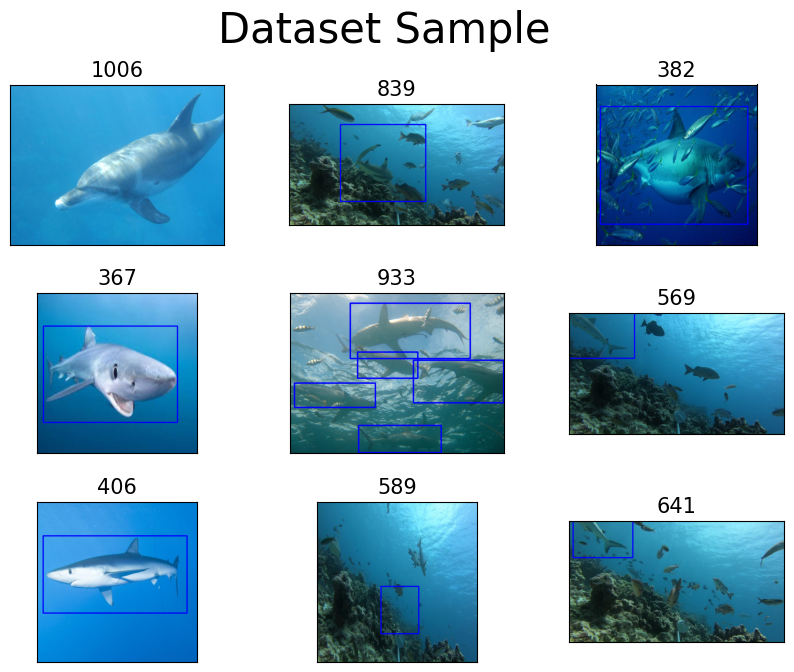

Training model...
Ultralytics YOLOv8.1.0 🚀 Python-3.10.12 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce RTX 4090, 24217MiB)
engine/trainer: task=detect, mode=train, model=None, data=, epochs=5, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_b

RuntimeError: Dataset '.' error ❌ nothing to open

In [6]:
model_experimentation(hyperparameters)